There are still a few unanswered questions about the simplified case studied in the other notebook. However, I will take a step forward now and add a degree of complexity to the model. Instead of perfectly known masses, I will take the masses as measured from some mass function. Whether or not I will need to make additionaly simplifications is unknown, but I'm hoping to just add another piece to the liklihood. 

In [124]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [125]:
from astropy.io import fits
#dataDir = '/home/sean/Data/BuzzardSims/'
dataDir = '/nfs/slac/g/ki/ki19/des/erykoff/clusters/mocks/Buzzard/buzzard-1.1/des_y5/redmapper_v6.4.7/halos/'
hdulist = fits.open(dataDir+'buzzard-v1.1-y5_run_00340_lambda_chisq.fit')
data = hdulist[1].data

import numpy as np
mass = data['M200']
print 'Rows:\t%d'%mass.shape[0]
rich = data['LAMBDA_CHISQ']
redshifts = data['Z']

mass = mass[rich>0]
redshifts = redshifts[rich>0]
rich = rich[rich>0]#slice off null values

mass = mass[redshifts<1.7]#for my approximation
rich = rich[redshifts<1.7]
redshifts = redshifts[redshifts<1.7]

logMass = np.log10(mass)
logRich = np.log10(rich)

offset = 13.5

from scipy.stats import linregress
b, logA, r, p, err = linregress(logMass-offset, logRich)
print 'a: %.3e\tb: %.3e'%(10**logA, b)
print 'R^2: %.3f'%r**2

Rows:	76997
a: 7.130e+00	b: 3.660e-01
R^2: 0.223


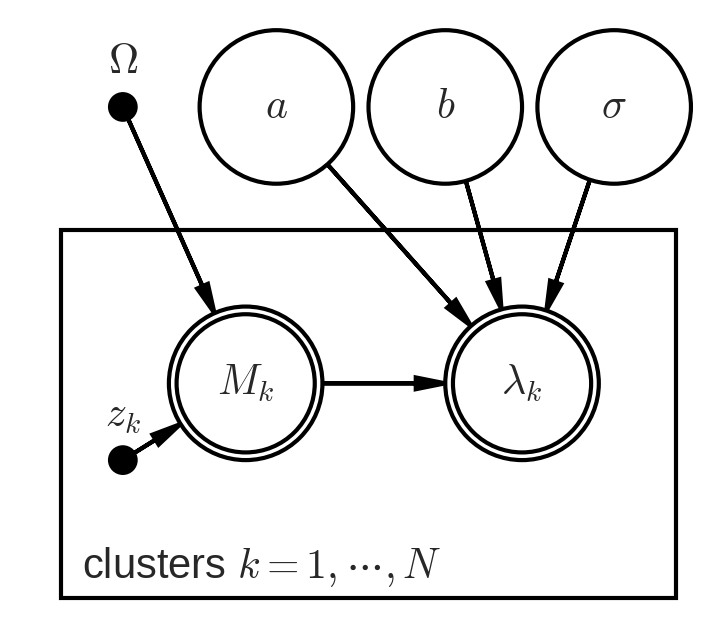

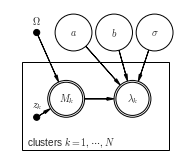

In [126]:
import daft

pgm = daft.PGM([2.3, 2.05], origin=[.3,.3], grid_unit = 2.6, node_unit=1.3, observed_style="inner")

pgm.add_node(daft.Node("cosmology", r"$\Omega$", .7,2,fixed =True))

pgm.add_node(daft.Node("scatter", r"$\sigma$", 2.3, 2))
pgm.add_node(daft.Node("b", r"$b$", 1.75, 2))
pgm.add_node(daft.Node("a", r"$a$", 1.2, 2))

pgm.add_node(daft.Node("redshift", r"$z_k$", 0.7,.85,fixed =True))

pgm.add_node(daft.Node("Mcluster", r"$M_k$", 1.1,1.1, observed = True))

pgm.add_node(daft.Node("richness", r"$\lambda_k$", 2,1.1,observed=True))

pgm.add_edge("a", "richness")
pgm.add_edge("b", "richness")
pgm.add_edge("scatter", "richness")
pgm.add_edge("Mcluster", "richness")

pgm.add_edge("redshift", "Mcluster")
pgm.add_edge("cosmology", "Mcluster")

pgm.add_plate(daft.Plate([.5,.5,2,1.1], label=r"clusters $k=1, \cdots, N$", shift = -.1))

pgm.render()
pgm.figure.savefig("modelPGM4.png", dpi = 300)
from IPython.display import Image
Image("modelPGM4.png")

This has the distribution:

$P(a,b,\sigma | \{M\}, \{\lambda\},\{z\}, \Omega ) = \prod_{k=1}^N{P(\lambda_k |\; M_k, a,b,\sigma)\;P(M_k | \Omega, z_k)\; P(a,b,\sigma)\;} $

In [127]:
#First, will need the parameters
vals = {}
z = [0.23, 1.5]
vals['Mp'] = [2.0e14, 1.0e14]#*10^14
vals['A'] = [1.944, 0.293]
vals['B1'] = [1.97, 3.07]
vals['B2'] = [0.7, 1.2]
vals['B3'] = [0.40, 0.73]

z_params = {}
from scipy.stats import linregress
for key, val in vals.iteritems():
    slope, intercept, r, p, stderr = linregress(z, val)
    z_params[key] = (slope, intercept)
    
def getMassParams(z):
    return {key:val[0]*z+val[1] for key,val in z_params.iteritems()}

def n_approx(m,z):
    params = getMassParams(z)
    return params['A']*np.exp(-params['B1']*(m/params['Mp']) \
                    -0.5*params['B2']*(m/params['Mp'])**2 \
                    -0.166*params['B3']*(m/params['Mp'])**3)

def log_n_approx(m,z):
    params = getMassParams(z)
    return -1*(params['B1']*(m/params['Mp']) \
                    +0.5*params['B2']*(m/params['Mp'])**2 \
                    +0.166*params['B3']*(m/params['Mp'])**3)+np.log(params['A'])

In [128]:
from scipy.stats import gamma, lognorm, expon
def log_prior(a,b,sigma):
    
    if any(x<0 for x in (a,sigma)):
        return -np.inf

    t = np.arctan(b)
    #if t<0 or t>np.pi/2:
    if t< -np.pi/2 or t> np.pi/2:
        return -np.inf
    
    #Hyperparameters
    lambda_a = 1.0
    sigma_a, sigma_b = 1,1
    
    p = 0
    #Exponential in log a
    p+= expon.logpdf(np.log(a), scale = 1/lambda_a)
    #Uniform in arctan(b)
    p+=np.log(2/np.pi)
    #Inv Gamma for sigma
    p-= gamma.logpdf(sigma,sigma_a, scale = sigma_b)
    return p

p_mass = np.sum(log_n_approx(mass,redshifts))
def log_liklihood(rich, M, a,b,sigma,z):
    p = 0
    #p+= np.sum(log_n_approx(M,z))#not normalized, if that's a problem i can approximate it. 
    p+=p_mass #It's a constant, save some time. 
    #a => logA
    #log Normal liklihood
    #It would appear my write up is incorrect...
    p+= np.sum(lognorm.logpdf(rich, sigma, loc = (b*(np.log(M)-offset)+np.log(a))))
    return p

def log_posterior(theta,rich, M,z):
    #print theta
    a,b,sigma = theta[:]
    p = log_prior(a,b,sigma)
    if np.isfinite(p):
        p+=log_liklihood(rich,M,a,b,sigma,z)
    return p

In [129]:
ndim = 3
nwalkers = 1000

a_mean, a_spread = 4, 1.5
b_mean, b_spread = .5, .25
sigma_mean, sigma_spread = 1, .5

pos0 = np.zeros((nwalkers, ndim))
for row in pos0:

    row[0] = a_mean+np.random.randn()*a_spread
    row[1] = b_mean+np.random.randn()*b_spread
    sig_try = -1
    while sig_try < 0:
        sig_try = sigma_mean+np.random.randn()*sigma_spread
    row[2] = sig_try

In [130]:
import emcee as mc
import multiprocessing
#nCores = multiprocessing.cpu_count()
nCores = 4
sampler = mc.EnsembleSampler(nwalkers, ndim, log_posterior, args=[rich, mass, redshifts],threads = nCores)
nsteps, nburn = 500, 100

In [131]:
print '-*'*25
print 'Num Dim:\t%d\nNum Walkers:\t%d\nNum Steps:\t%d\nNum Burn:\t%d'%(ndim, nwalkers, nsteps, nburn)
print '-*'*25

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Num Dim:	3
Num Walkers:	1000
Num Steps:	500
Num Burn:	100
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


In [132]:
np.random.seed(0)#"random"

sampler.run_mcmc(pos0, nsteps);

In [133]:
chain = sampler.chain[:,nburn:, :].reshape((-1, ndim))
sampler.pool.terminate()#there's a bug in emcee that creates daemon threads. This kills them.
#del(sampler)

MAP = chain.mean(axis = 0)
labels = ['logA', 'b', 'sigma']
for label, val in zip(labels, MAP):
    print '%s:\t%.3f'%(label, val)

logA:	6.575
b:	0.359
sigma:	1.281


In [134]:
print MAP[0], 10**logA
print MAP[1], b

6.5748616983 7.13034101009
0.358522296011 0.366003356777


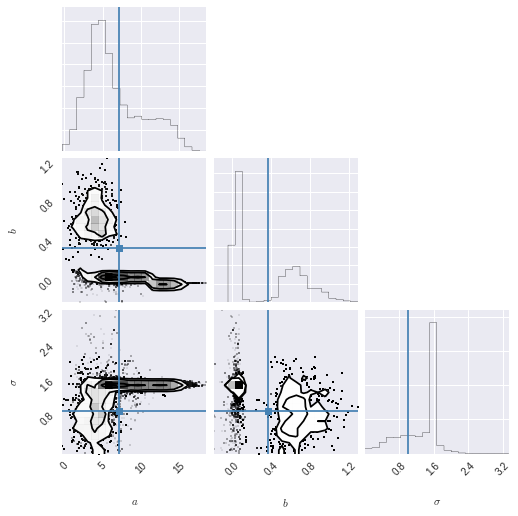

In [135]:
from corner import corner
titles = ['$a$', '$b$', '$\sigma$']
sigma_true = 1 #just a guess so this will plot
corner(chain, labels = titles , truths = [10**logA, b, sigma_true]);

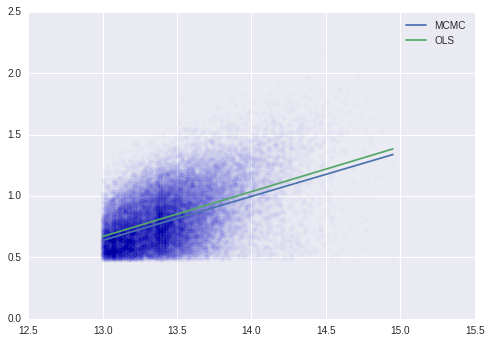

In [136]:
plt.scatter(logMass, logRich, alpha = .01)
plt.plot(logMass, MAP[1]*(logMass-offset)+np.log10(MAP[0]), label = 'MCMC')
plt.plot(logMass, b*(logMass-offset)+logA, label = 'OLS')
plt.legend(loc= 'best')

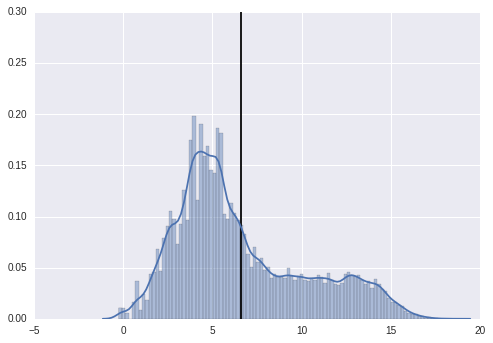

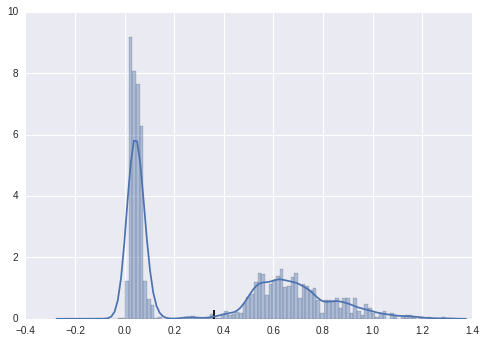

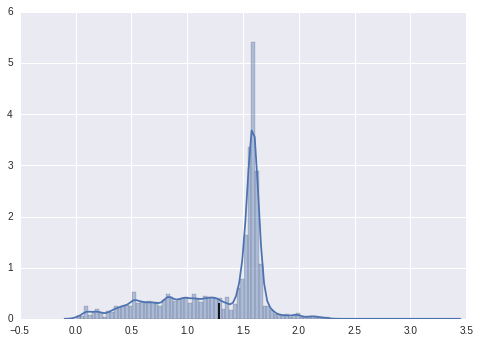

In [137]:
for i in xrange(3):
    sns.distplot(chain[:,i], bins = 100)
    plt.vlines(MAP[i], 0, .3)
    plt.show()

So this looks about the same as before, which isn't surprising. The only thing that's obviously different is the fit isn't as good (less steps not weird) and a isn't obviously bimodal like it was last time. Corner plot does show it well though. Its not surprising because the liklihood of the mass given redshift and cosmology won't change at each step; it's a constant offset and may as well not be there as far as MCMC is concerned. So, it works with no bugs but it doesn't tell me anything about how good it is. I'll need to do more direct comparison to the data I have. 